### **Лабораторная работа № 2**
### Линейная нейронная сеть. Правило обучения Уидроу-Хоффа

**Цель работы**: исследование свойств линейной нейронной сети и алгоритмов ее обучения, применение сети в задачах аппроксимации и фильтрации

Выполнил: Семин А. В., М8О-406Б-20

Вариант 21.

Импортируем нужные библиотеки

In [22]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

### Определим нейронную сеть

Создадим класс линейной нейронной сети, выполняющей перемножение матрицы весов и матрицы входа с прибавлением вектора смещения

In [23]:
class Adaline(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))
        else:
            self.register_parameter('bias_term', None)

    def forward(self, x):
        x = x @ self.weights
        if self.bias_term is not None:
            x += self.bias_term
        return x

Определим функцию обучения

In [24]:
def fit(model, x_train, y_train, criterion, optimizer, epochs):
    step = 10
    if epochs > 100:
        step = 100
    losses = []
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        outp = model(x_train)

        loss = criterion(outp.view(-1), y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if (epoch +1) % step == 0:
            print(f'Epoch = {epoch + 1}, t_loss = {loss.item()}')
    return losses

Определим функцию предсказания

In [25]:
def predict(model, x_test):
    with torch.no_grad():
        model.eval()
        outp = model(x_test)
    return outp

### Решение задания 1 - аппроксимации функции на один шаг вперед

Зададим входные данные и создадим датасет

In [26]:
D = 5  # задержки

def x(interval):
    return np.cos(-3 * interval**2 + 10 * interval - 5) - np.cos(interval)

interval = np.arange(0.5, 5, 0.01)
X = x(interval)

delays = [X[i:i+D] for i in range(len(X) - D)]
points = X[D:]

In [27]:
def shuffle(x, y):
    p = np.random.permutation(len(x))
    return x[p], y[p]

In [28]:
train_data = shuffle(np.array(delays), np.array(points))
x_train = torch.FloatTensor(train_data[0])
y_train = torch.FloatTensor(train_data[1])

Нейросеть принимает на вход `D` дискрет и имеет один выходной нейрон - предсказываемую дискрету. 
Функция потерь - MSE

In [29]:
ad = Adaline(D, 1)
loss_func = nn.MSELoss()
optimizer = torch.optim.SGD(ad.parameters(), lr=0.05)

Обучим модель

In [30]:
losses = fit(ad, x_train, y_train, loss_func, optimizer, 50)

Epoch = 10, t_loss = 0.25217902660369873
Epoch = 20, t_loss = 0.13149818778038025
Epoch = 30, t_loss = 0.10675811767578125
Epoch = 40, t_loss = 0.09527634084224701
Epoch = 50, t_loss = 0.08627685159444809


Посмотрим на график функции потерь (MSE)

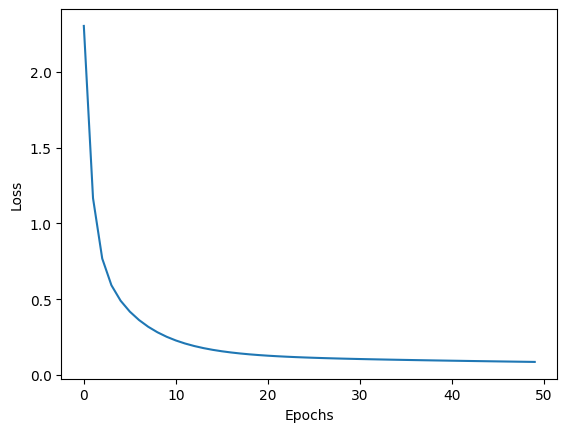

In [31]:
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Вычислим предсказания модели для каждого набора точек и  посчитаем отклонения от реальных значений

In [32]:
X_predicted = [X[i] for i in range(0,D)]
err = []

for i in range(0, len(points)):
    x_test = torch.FloatTensor(np.array(delays[i]))
    next_prediction = predict(ad, x_test).numpy().tolist()
    X_predicted += next_prediction
    err.append(next_prediction - points[i])

Сравним результат предсказания и истинную последовательность

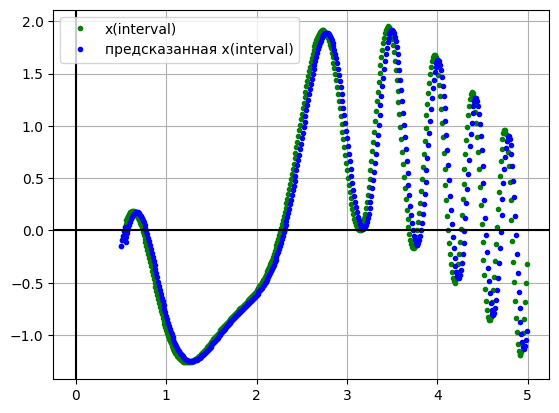

In [33]:
plt.plot(interval, X, '.', color="g", label='x(interval)')
plt.plot(interval, X_predicted, '.', color="blue", label='предсказанная x(interval)')
plt.grid()
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.legend()
plt.show()

Отобразим график отклонений от реальных значений

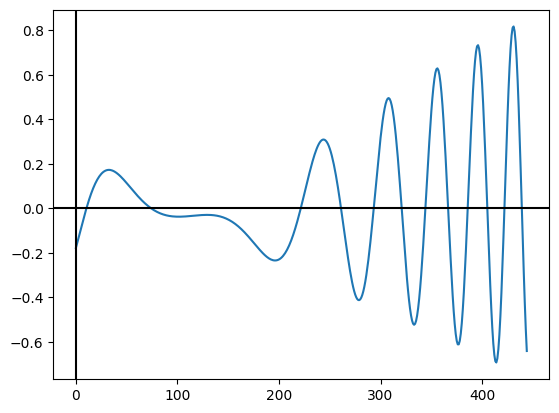

In [34]:
plt.plot(err)
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.show()

### Решение задания 3 - подавление помех

Определим входные данные для задачи подавления помех

In [35]:
D = 4

def true_signal(interval):
    return np.cos(-3 * interval**2  + 5*interval + 10)

def noized_signal(interval):
    return (1/6) * np.cos(-3 * interval**2 + 5*interval + 3*np.pi / 2)

interval = np.arange(0, 2.5, 0.01)
X = true_signal(interval).tolist()
Y = noized_signal(interval).tolist()

noized_delays = [Y[i:i+D] for i in range(0, len(Y) - D)] # зашумленный  
true_points = X[D:] # истинный

In [36]:
train_data = shuffle(np.array(noized_delays), np.array(true_points))

x_train = torch.FloatTensor(train_data[0])
y_train = torch.FloatTensor(train_data[1])

Вторая нейросеть также принимает на вход `D` зашумленных дискрет и имеет один выходной нейрон

In [37]:
adaline2 = Adaline(D, 1)
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(adaline2.parameters(), lr=0.05)

Обучим модель

In [38]:
losses2 = fit(adaline2, x_train, y_train, loss_function, optimizer, 1000)

Epoch = 100, t_loss = 0.29306042194366455
Epoch = 200, t_loss = 0.2753605842590332
Epoch = 300, t_loss = 0.267533540725708
Epoch = 400, t_loss = 0.2639619708061218
Epoch = 500, t_loss = 0.2622251808643341
Epoch = 600, t_loss = 0.2612796425819397
Epoch = 700, t_loss = 0.260675847530365
Epoch = 800, t_loss = 0.26021987199783325
Epoch = 900, t_loss = 0.25982823967933655
Epoch = 1000, t_loss = 0.25946497917175293


Посмотрим на график функции потерь (MSE)

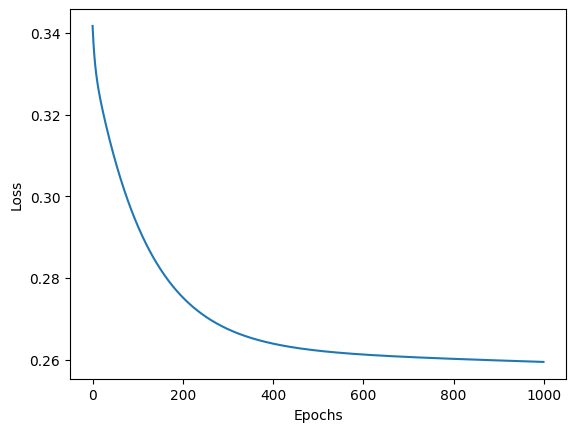

In [39]:
plt.plot(losses2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Вычислим предсказания модели для каждого набора точек и  посчитаем отклонения от реальных значений

In [40]:
X_predicted = [X[i] for i in range(0,D)]
err2 = []

for i in range(0, len(true_points)):
    x_test = torch.FloatTensor(np.array(noized_delays[i]))
    next_prediction = predict(adaline2, x_test)
    X_predicted += next_prediction.numpy().tolist()
    err2 += (next_prediction - points[i]).numpy().tolist()

Отобразим три сигнала для сравнения результата

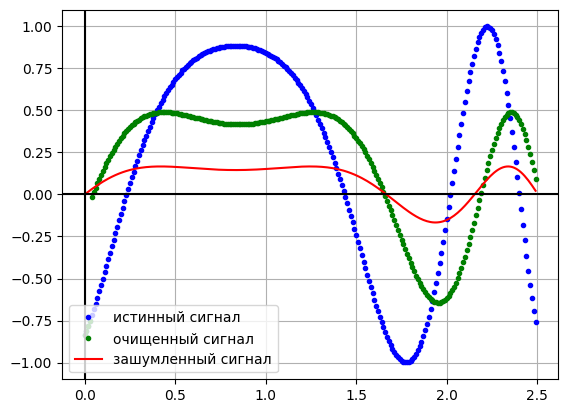

In [43]:
plt.plot(interval, X, '.', color="b", label='истинный сигнал')
plt.plot(interval, X_predicted, '.', color="green", label='очищенный сигнал')
plt.plot(interval, Y, '-', color="r", label='зашумленный сигнал')
plt.grid()
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.legend()
plt.show()

Отобразим график отклонений

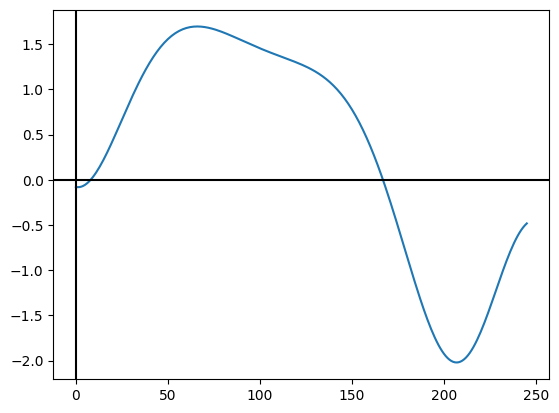

In [42]:
plt.plot(err2)
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.show()

**`Вывод:`** в ходе данной работы была построена линейная нейросетевая модель, которая была применена для решения двух задач:
1) аппроксимации функции
2) подавления помех в сигнале

C задачей аппроксимации нейросеть справилась отлично, однако подавление помех выполнила не так хорошо, как хотелось бы: нейросеть при подавлении помех приблизилась к истинному сигналу, однако не повторила его в точности из-за сильного отклонения зашумленного сигнала